### 1. Loading and normalizing CIFAR10

In [16]:
!pip install -q torch==1.7.0 torchvision
import torch
print(torch.__version__)

1.7.0+cu101


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
'''
  transforms: image file을 torch tensor읽고 변환해주는 library
  - ToTensor: 1~0 값으로 변환 #0: 제일 어두움 #1: 제일 밝음
  - transforms.Normalize: 각 이미지에 대해 이미지 tensor들을 normalization해주는 것, RGB채널에 대해 세개의 값 (R=0.5, G=0.5, B=0.5)에 대한 중간값 
'''
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


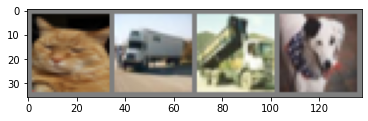

  cat truck truck   dog
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([3, 9, 9, 5])


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
                # dateriter.next():  자동으로 다음 batch를 건내줌


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

'''
ground truth: True y ('dog ship bird plane')
'''

# 추가 
print(type(images), images.shape)
'''
out: <class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
images.shape을 출력하면 torch.Size[4, 3, 32, 32]로 나오는데
- 여기서 4가 batch_size=4를 말함, 
즉, 해당 batch에서 건내받은 tensor들로, 각각의 사진을 말한다.이미지를 불러온 것.(batch_size = 4 -> 이미지)
- RGB = 3  (1은 gray scale)
- 32, 32 = 가로 *세로 
- 따라서 32*32*3(RGB) 차원의 image로 변환됨
'''

print(type(labels), labels.shape, labels)
'''
images와 labels이 잘 aligment되어 있는지 확인해줘야 함
out: <class 'torch.Tensor'> torch.Size([4]) tensor([3, 9, 9, 5])
tensor([3, 9, 9, 5]) 는 앞서 classes에서 선언해준 label값
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
-> cat, truck, truck, dog
'''



### 2. Define MLP

In [17]:
# ============= Model Architecture =========== #

import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
  def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
    super(MLP, self).__init__()
    # self로 다시 인자들을 받아줌, 다음 forward에서도 이 인자들을 받을 수 있기 때문에.
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.hid_dim = hid_dim
    self.n_layer = n_layer
    self.act = act

    self.fc = nn.Linear(self.in_dim, self.hid_dim)    #fc=fully connected -> linear
    self.linears = nn.ModuleList()
    
    for i in range(self.n_layer-1):           
      # n_layer 를 hidden layer를 생각할 때는 n_layer로 설정, n_layer를 input+hidden layer로 생각할 때는 n_layer -1로 설정
      # 이 코드는 n_layer를 hidden layer로 생각하고, 마지막 layer는 out_dim으로 보내주기 위해 n_layer-1까지만 반복해 줌
      self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
    self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

    # activation function
    if self.act == 'relu':
      self.act = nn.ReLU()

  def forward(self, x):
    x = self.act(self.fc(x))
    for fc in self.linears:   # 이렇게 하면 fc에 바로 nn.Linear object가 바로 반환됨
      x = self.act(fc(x))
      # 마지막 layer에는 ReLU를 씌우면 안 됨, 그 이유는 모두 0으로 truncate되어 classification을 잘못할 수 있음 -> 따라서 위 def에서 fc2로 actvation function을 제외한 fc를 만들어 주어 이제 활용함
    x = self.fc2(x)
    return x

net = MLP(3072, 10, 100, 4, 'relu')  # 3072=input의 차원 32*32*3
print(net)

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


### 3. Define a Loss function and optimizer

In [18]:
# ======= Optimizer, Function ========= #

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print(criterion)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### 4. Train the network

In [20]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

torch.Size([4, 3, 32, 32])


RuntimeError: ignored

In [24]:
# ======== Train ========== #

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data  
        inputs = inputs.view(-1, 3072)      # -1의 의미: 지정한 dimension을 맞추고 난 다음, 남아있는 dimension을 몫으로 채워준다는 것을 의미
                                            # 즉, (-1, 3072): view기능은 -1자리에 3072를 나눈 값이 들어옴 / **view는 차원을 다루고자 할 때 쉽게 manipulation할 수 있음
        #print(inputs.shape) #4*3*32*32(12288) 한 batch에는 한 element가 들어가 있음, 쭉 일렬로 늘려놓으면 12288개의 tensor가 됨 

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.341
[1,  4000] loss: 1.360
[1,  6000] loss: 1.374
[1,  8000] loss: 1.353
[1, 10000] loss: 1.355
[1, 12000] loss: 1.351
[2,  2000] loss: 1.277
[2,  4000] loss: 1.305
[2,  6000] loss: 1.297
[2,  8000] loss: 1.306
[2, 10000] loss: 1.288
[2, 12000] loss: 1.303
Finished Training


### 5. Test the network on the test data

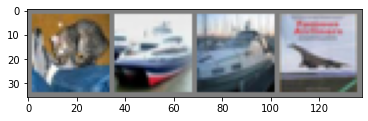

GroundTruth:    cat  ship  ship plane


In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [27]:
# ===== Measure Test Accuracy ========== # 
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(-1, 3072)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


# *** Modify DataLoader ***

- split data: serching pytorch dataset split

In [31]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset,batch_size=4, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,

                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### - Loss, Accuracy for Validation set

In [37]:
# ===== Measure Validation Loss, Accuracy ========== # 
correct = 0
total = 0
val_loss = 0 

with torch.no_grad():
    for data in valloader:
        images, labels = data
        images = images.view(-1, 3072)
        outputs = net(images)
        
        ###############
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        ###############
      
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    ###############
    #print(len(valloader))
    val_loss = val_loss/ len(valloader)  #batch로 나눠줌 (1000개의 data를 4개로 나눠줌=2500)
    #print(val_loss)
    ##############

##############
acc = 100 * correct / total 
print('Accuracy of the network on the 10000 test images: {:2.2f}% Loss:{:2.2f}'.format (acc, val_loss))

Accuracy of the network on the 10000 test images: 57.01% Loss:1.22


# Experiment

In [54]:
def experiment(args):

  net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
  print(net)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)


  for epoch in range(args.epoch):  # loop over the dataset multiple times

    # ======== Train ========== #
      running_loss = 0.0
      train_loss = 0.0 
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data  
          inputs = inputs.view(-1, 3072)      # -1의 의미: 지정한 dimension을 맞추고 난 다음, 남아있는 dimension을 몫으로 채워준다는 것을 의미
                                              # 즉, (-1, 3072): view기능은 -1자리에 3072를 나눈 값이 들어옴 / **view는 차원을 다루고자 할 때 쉽게 manipulation할 수 있음
          #print(inputs.shape) #4*3*32*32(12288) 한 batch에는 한 element가 들어가 있음, 쭉 일렬로 늘려놓으면 12288개의 tensor가 됨 

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          train_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))



      # ===== Measure Validation Loss, Accuracy ========== # 
      correct = 0
      total = 0
      val_loss = 0 
      
      with torch.no_grad():
          for data in valloader:
              images, labels = data
              images = images.view(-1, 3072)
              outputs = net(images)
              
              ###############
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              ###############
            
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
          
          ###############
          #print(len(valloader))
          val_loss = val_loss/ len(valloader)  #batch로 나눠줌 (1000개의 data를 4개로 나눠줌=2500)
          val_acc = 100 * correct / total 
          #print(val_loss)
          ##############

  print('Epoch: {}, Train Loss: {}, Val Loss: {},  Va Acc: {}'.format(epoch, train_loss, val_loss, val_acc))

In [55]:
import argparse

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")      #terminal이 아니라 jupyter이기 때문에 ""를 써줌

args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9
args.epoch = 2

experiment(args)


MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)
[1,  2000] loss: 2.296
[1,  4000] loss: 4.395
[1,  6000] loss: 6.309
[1,  8000] loss: 8.100
[1, 10000] loss: 9.818
[2,  2000] loss: 1.653
[2,  4000] loss: 3.291
[2,  6000] loss: 4.901
[2,  8000] loss: 6.464
[2, 10000] loss: 8.028
Epoch: 1, Train Loss: 16055.945657581091, Val Loss: 1.5945568535327912,  Va Acc: 43.32


### Cuda 

In [63]:
# ======== cuda 사용 ============== #

def experiment(args):

  net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
  #######################
  net.cuda()

  print(net)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)


  for epoch in range(args.epoch):  # loop over the dataset multiple times

    # ======== Train ========== #
      running_loss = 0.0
      train_loss = 0.0

      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data  
          inputs = inputs.view(-1, 3072)      # -1의 의미: 지정한 dimension을 맞추고 난 다음, 남아있는 dimension을 몫으로 채워준다는 것을 의미
                                              # 즉, (-1, 3072): view기능은 -1자리에 3072를 나눈 값이 들어옴 / **view는 차원을 다루고자 할 때 쉽게 manipulation할 수 있음
          #print(inputs.shape) #4*3*32*32(12288) 한 batch에는 한 element가 들어가 있음, 쭉 일렬로 늘려놓으면 12288개의 tensor가 됨 
          ##############################################
          inputs = inputs.cuda()
          labels = labels.cuda()


          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          train_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))


      # ===== Measure Validation Loss, Accuracy ========== # 
      correct = 0
      total = 0
      val_loss = 0 
      
      with torch.no_grad():
          for data in valloader:
              images, labels = data
              images = images.view(-1, 3072)

              ######################################
              images = images.cuda()
              labels = labels.cuda()

              outputs = net(images)
              
              ###############
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              ###############
            
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
          
          ###############
          #print(len(valloader))
          val_loss = val_loss/ len(valloader)  #batch로 나눠줌 (1000개의 data를 4개로 나눠줌=2500)
          val_acc = 100 * correct / total 
          #print(val_loss)
          ##############

  print('Epoch: {}, Train Loss: {}, Val Loss: {},  Va Acc: {}'.format(epoch, train_loss, val_loss, val_acc))


  # ===== Evaluation ========== # 
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.view(-1, 3072)
          images = images.cuda()
          labels = labels.cuda()

          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      
      test_acc = 100 * correct / total
    

  

In [64]:
import argparse

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")      #terminal이 아니라 jupyter이기 때문에 ""를 써줌

args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9
args.epoch = 2

list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

for var1 in list_var1:
  for var2 in list_var2:
    args.n_layer = var1
    args.hid_dim = var2
    result = experiment(args)
    print(result)

MLP(
  (fc): Linear(in_features=3072, out_features=50, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (act): ReLU()
)
[1,  2000] loss: 2.193
[1,  4000] loss: 4.083
[1,  6000] loss: 5.850
[1,  8000] loss: 7.568
[1, 10000] loss: 9.252
[2,  2000] loss: 1.616
[2,  4000] loss: 3.228
[2,  6000] loss: 4.805
[2,  8000] loss: 6.393
[2, 10000] loss: 7.928
Epoch: 1, Train Loss: 15856.401718229055, Val Loss: 1.567282311272621,  Va Acc: 44.45
None
MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_feature